In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

print(os.getcwd())
sys.path.append(str(Path('../src').resolve()))

/media/dicarlod/SSD_2/diego/Code/INCANT/python/notebooks


In [3]:
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import open3d as o3d

from tqdm.auto import tqdm

import scipy.interpolate as interpolate
from matplotlib.colors import LogNorm

from tqdm import tqdm

from implicits import SIREN, MFN, RFF, continuous_diff
from train import train_siren
from opening_ply import ply_to_npy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/media/dicarlod/SSD_2/diego/Code/INCANT/python/notebooks


In [4]:
# Load Data
path_to_data0 = Path(f"../../data/full_data/LyonSone0.ply")
path_to_data1 = Path(f"../../data/full_data/LyonSone1.ply")

data0 = ply_to_npy(path_to_data0)
data1 = ply_to_npy(path_to_data1)
col_names = ["x", "y", "z", "t", "label_ch"]
print(data0.shape)
print(data1.shape)

data0 = np.concatenate([data0[:,:3], np.zeros([data0.shape[0], 1]), data0[:, 3:]], axis=1)
data1 = np.concatenate([data1[:,:3], np.ones([data1.shape[0], 1]), data1[:, 3:]], axis=1)

data = np.concatenate([data0, data1], axis=0)
print(data.shape)

(5979065, 4)
(5987920, 4)
(11966985, 5)


In [5]:
do_preprocessing = False
if do_preprocessing:
    pts = data[:,:3]
    # Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    print(len(pcd.points))
    # o3d.visualization.draw_geometries([pcd])
    ## Downsample
    pcd = pcd.voxel_down_sample(voxel_size=0.05)
    print(len(pcd.points))
    ## prune points with horizontal norms
    radius =  3. # metres
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=30))
    dist, az, el = [1000, 0, 80]
    campera_loc_car = np.array([
        dist*np.cos(np.deg2rad(el))*np.cos(np.deg2rad(az)),
        dist*np.cos(np.deg2rad(el))*np.sin(np.deg2rad(az)),
        dist*np.sin(np.deg2rad(el))
    ])
    pcd.orient_normals_towards_camera_location(
        camera_location=campera_loc_car)
    # o3d.visualization.draw_geometries([pcd], point_show_normal=True)

    normals = np.asarray(pcd.normals)
    hpnorm = np.array([0,0,1])

    angles = np.arccos(np.abs(normals @ hpnorm) / (
        np.linalg.norm(normals, axis=1) * np.linalg.norm(hpnorm) ))

    # plt.hist(np.rad2deg(angles), bins=90)
    # plt.show()

    print(np.rad2deg(angles))
    ind = np.where(np.abs(np.rad2deg(angles)) > 70)[0]
    pcd = pcd.select_by_index(ind, invert=True)
    print(len(pcd.points))

    # o3d.visualization.draw_geometries([pcd], point_show_normal=True)

    ## prune isolated points
    radius = 1 # meter
    nb_points = 1
    cl, ind = pcd.remove_radius_outlier(nb_points=nb_points, radius=radius)
    pcd = pcd.select_by_index(ind)
    # outlier_cloud = downpcd.select_by_index(ind, invert=True)
    # o3d.visualization.draw_geometries([pcd], point_show_normal=True)
    print(len(pcd.points))

    data_t0_post = np.array(pcd.points)
    data_t0_post = np.concatenate([data_t0_post, np.zeros((data_t0_post.shape[0],1))], axis=-1)
    data_t0 = data_t0_post

In [6]:
# Create dataloader
class MarcoDataset(torch.utils.data.Dataset):
    def __init__(self, data, col_names, device):
        self.col_names = col_names
        self.data = data
        n_obs = self.data.shape[0]
        
        coords = torch.Tensor(self.data[:,[0,1,3]])
        target = torch.Tensor(self.data[:,2][:,None])

        # label
        self.label = torch.Tensor(self.data[:,-1][:,None])
        
        # target normalization between [-1,1] for SIREN
        self.target_mean = torch.mean(target, dim=0, keepdim=True)
        target = target - self.target_mean
        self.target_range = 1.1 * torch.max(torch.abs(target))
        self.target = target / self.target_range

        # coordinate normalization between [-1,1] for SIREN
        coords_n = coords - torch.mean(coords, dim=0, keepdim=True)
        coords_n = coords_n / (1.1 * torch.max(torch.abs(coords_n), dim=0, keepdim=True)[0])
        coords[:,:2] = coords_n[:,:2]
        self.coords = coords

        self.data = torch.concat([self.coords, self.target, self.label], dim=-1)
        
        for d in range(2):
            assert torch.max(self.coords[:,d]) <  1
            assert torch.min(self.coords[:,d]) > -1
            assert torch.any(self.coords[:,d] <= 0)
        
        print('Coords')
        print(torch.min(self.coords, dim=0)[0])
        print(torch.mean(self.coords, dim=0)[0])
        print(torch.max(self.coords, dim=0)[0])

        print('Targets')
        print(torch.min(self.target, dim=0)[0])
        print(torch.mean(self.target, dim=0)[0])
        print(torch.max(self.target, dim=0)[0])
        
        
    def __len__(self):
        return self.coords.shape[0]
    
    def __getitem__(self, idx):
        coords = self.coords[idx,:]
        target = self.target[idx,:]
        return (coords, target)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dset = MarcoDataset(data, col_names, device)
# indeces = list(range(0, len(dset_train), 1))
# dset_train = torch.utils.data.Subset(dset_train, indeces)


n_obs = len(dset)
print("N obs", n_obs)

n_train  = int((80 / 100) * n_obs)
n_val = n_obs - n_train
print("N tra", n_train)
print("N val", n_val)

dset_train, dset_val = torch.utils.data.random_split(dset, [n_train, n_val])

n_points = 2048
xy_cont = np.stack(np.meshgrid(
    np.linspace(-.9, .9, n_points),
    np.linspace(-.9, .9, n_points),
    np.array([0.,1.]),
    indexing='ij'
), axis=-1)
print(xy_cont.shape)
xy_cont = torch.from_numpy(xy_cont).float().to(device)
xy_cont = xy_cont.view(-1,3)
print(xy_cont.shape)


cuda
Coords
tensor([-0.9091, -0.9091,  0.0000])
tensor(-0.0006)
tensor([0.7304, 0.7247, 1.0000])
Targets
tensor([-0.2923])
tensor(1.1882e-07)
tensor([0.9091])
N obs 11966985
N tra 9573588
N val 2393397
(2048, 2048, 2, 3)
torch.Size([8388608, 3])


In [8]:
params = {'batch_size': int(2**18),
 'feature_space': 256,
 'feature_time': 20,
 'hidden_dim': 256,
 'hidden_num': 5,
 'learning_rate': 1e-4}
epochs = 1000

class INCANT(torch.nn.Module):
    def __init__(self, in_dim, out_dim, hidden_num, hidden_dim, feature_scales, do_skip):
        super(INCANT, self).__init__()
        self.model = SIREN(in_dim, out_dim, hidden_num, hidden_dim, feature_scales)
        # self.model = RFF(in_dim, out_dim, hidden_num, hidden_dim, 'relu', feature_dim=1024, feature_scale=feature_scales[0] )
        self.do_skip = do_skip
    # extend SIREN forward
    def forward(self, xin):
        if self.do_skip:
            for l, layer in enumerate(self.model.model):
                if layer.is_first:
                    x = layer(xin)
                elif layer.is_last:
                    out = layer(x)
                else:
                    x = layer(x) + x if l % 2 == 1 else layer(x)
        else:
            out = self.model(xin)
        return torch.tanh(out)

model = INCANT(
    in_dim = 3,
    out_dim = 1,
    hidden_num = params['hidden_num'],
    hidden_dim = params['hidden_dim'],
    feature_scales = [params['feature_space'], params['feature_space'], params['feature_time']],
    do_skip=True,
)
epochs = 100


In [9]:
best_model, results_dict = train_siren(
        model, dset_train, dset_val, device, epochs, loss_name='MSE',
        batch_size=params['batch_size'], learning_rate=params['learning_rate'],
        val_interval=10, trial=None, xy_cont=xy_cont, lam_tv = 0.0, clip_grad=False)

Lr 0.0001
Batch size 262144
9573588
2393397


  0%|          | 0/100 [00:00<?, ?it/s]

Starting traning


/home/dicarlod/anaconda3/envs/incant_env/lib/python3.10/site-packages/torchlars/lars.py:140: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/torch/csrc/utils/python_arg_parser.cpp:1420.)
  p.grad.add_(weight_decay, p.data)


Validation loss decreased (inf --> 0.068278) [+inf].  Saving model ...
Validation loss decreased (0.068278 --> 0.014592) [+0.053686].  Saving model ...
Validation loss decreased (0.014592 --> 0.013091) [+0.001501].  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.013091 --> 0.006422) [+0.006669].  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
Validation loss decreased (0.006422 --> 0.006152) [+0.000270].  Saving model ...
Validation loss decreased (0.006152 --> 0.004466) [+0.001686].  Saving model ...
Validation loss decreased (0.004466 --> 0.004219) [+0.000247].  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Validation loss decreased (0.004219 --> 0.004048) [+0.000171].  Saving model ...
Validation loss decreased (0.004048 --> 0.003835) [+0.000213].  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.003835 --> 0.0

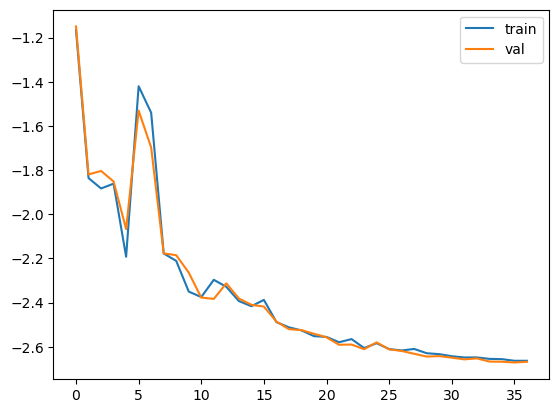

In [10]:
plt.plot(np.log10(results_dict['loss_train']), label='train')
plt.plot(np.log10(results_dict['loss_val']), label='val')
plt.legend()
plt.show()

In [11]:
best_model_path = Path("./checkpoint.pt")
model.load_state_dict(torch.load(best_model_path))
best_model = model

In [12]:
coord_test, reference = dset_val[::2]
coord_test = coord_test.to(device)
reference = reference.to(device)

print(coord_test)
print(coord_test.dtype)
best_model.to(device)
estimaded = best_model(coord_test)


estimaded = (estimaded * dset.target_range.to(device)) + dset.target_mean.to(device)
reference = (reference * dset.target_range.to(device)) + dset.target_mean.to(device)

error = torch.abs(estimaded - reference)
mae = torch.mean(error)
std = torch.std(error)
mse = torch.mean(error**2)
smse = torch.sqrt(mse)
print(f'MAE: {mae.item():0.4f} MSE: {mse.item():0.4f} STD: {std.item():0.4f} rootMSE: {smse.item():0.4f}')

tensor([[-0.4144, -0.0280,  0.0000],
        [ 0.0065, -0.1941,  0.0000],
        [-0.4423,  0.1068,  0.0000],
        ...,
        [ 0.0334, -0.5068,  1.0000],
        [ 0.0593, -0.2610,  0.0000],
        [ 0.3577,  0.4098,  1.0000]], device='cuda:0')
torch.float32
MAE: 1.4826 MSE: 8.1749 STD: 2.4447 rootMSE: 2.8592


In [ ]:
# coord_test, reference = dset_train[:]
# print(coord_test)
# print(coord_test.dtype)
# best_model.eval()
# estimaded = best_model(coord_test)

# plt.scatter(coord_test[:,0].detach().cpu().numpy(), 
#             coord_test[:,1].detach().cpu().numpy(), 
#             c=estimaded.detach().cpu().numpy())
# plt.show()

# plt.scatter(coord_test[:,0].detach().cpu().numpy(), 
#             coord_test[:,1].detach().cpu().numpy(), 
#             c=reference.detach().cpu().numpy())
# plt.show()

# estimaded = (estimaded * dset_t0.target_range) + dset_t0.target_mean
# reference = (reference * dset_t0.target_range) + dset_t0.target_mean

# error = torch.abs(estimaded - reference)
# mae = torch.mean(error)
# std = torch.std(error)
# mse = torch.mean(error**2)
# smse = torch.sqrt(mse)
# print(f'MAE: {mae.item():0.4f} MSE: {mse.item():0.4f} STD: {std.item():0.4f} sMSE: {smse.item():0.4f}')

# plt.scatter(coord_test[:,0].detach().cpu().numpy(), 
#             coord_test[:,1].detach().cpu().numpy(), 
#             c=error.detach().cpu().numpy())
# plt.show()


In [19]:
n_points = 1024

est = []

for t in [0., 0.2, 0.5, 1.]:
    xy_cont = np.stack(np.meshgrid(
        np.linspace(-0.9, 0.9, n_points),
        np.linspace(-0.9, 0.9, n_points),
        np.array([t]),
        indexing='ij'
    ), axis=-1).reshape(-1,3)

    xy_cont = torch.from_numpy(xy_cont).float().to(device)

    best_model.eval()
    estimaded = best_model(xy_cont)
    estimaded = estimaded.reshape(n_points, n_points)

    est.append([xy_cont, estimaded])

    plt.figure(figsize=(6,6))
    plt.imshow(estimaded.detach().cpu().numpy())
    # plt.colorbar()
    plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 47.54 GiB total capacity; 45.51 GiB already allocated; 578.00 MiB free; 45.93 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

tensor(1024.)
tensor(115.5630)


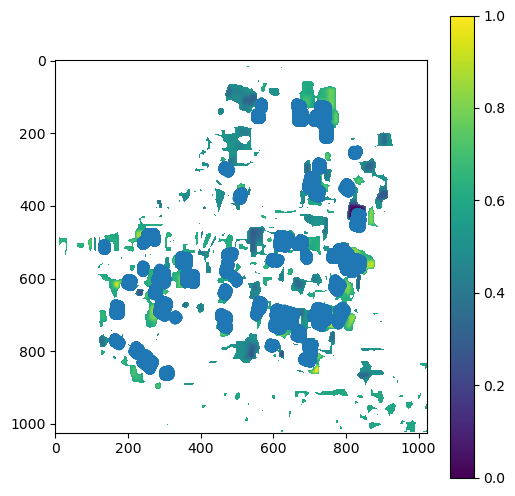

In [21]:
data = dset.data
data_add = ((data[data[:,-1] == 1] / 2) + 0.5) * 1024.
data_rem = data[data[:,-1] == 0]

print(torch.max(data_add))
print(torch.min(data_add))

diff = est[1][1] - est[0][1]
diff[torch.abs(diff) < 0.03] = np.NAN

plt.figure(figsize=(6,6))
plt.imshow(diff.detach().cpu().numpy().T)
plt.scatter(data_add[:,0], data_add[:,1], marker='o')
plt.colorbar()
plt.show()

In [15]:
print(xy_cont.shape)
print(estimaded.shape)  
est_dim = est[0][1] - est[1][1]
pts = torch.concat([xy_cont[:,:2], est_dim.view(-1,1)], dim=-1).view(-1,3).detach().cpu().numpy()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)

o3d.visualization.draw_geometries([pcd])
# o3d.io.write_point_cloud("data_t0_siren_tv_norm.pcd", pcd)


torch.Size([1048576, 3])
torch.Size([1024, 1024])


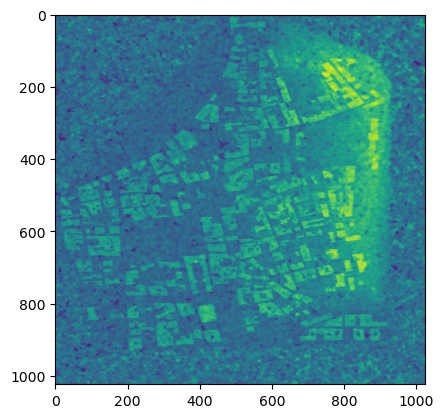

In [18]:
est_dim.shape
plt.imshow(est_dim.detach().cpu().numpy())

In [ ]:
# Plot the surface.
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x = pts[:,0].reshape(512,512)
y = pts[:,1].reshape(512,512)                                                                                                                                                                                                                                               
z = pts[:,2].reshape(512,512)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [ ]:
pcd_t0 = o3d.io.read_point_cloud("./data_t0_siren_tv_norm.pcd")
pcd_t1 = o3d.io.read_point_cloud("./data_t1_siren_tv_norm.pcd")

pts_diff = pts
pts_diff[:,-1] = np.array(pcd_t1.points)[:,2] - np.array(pcd_t0.points)[:,2]

In [ ]:
pcd_t0 = o3d.io.read_point_cloud("./data_t0_siren_tv_norm.pcd")
o3d.visualization.draw_geometries([pcd_t1])

In [ ]:
pcd_diff = o3d.geometry.PointCloud()
pcd_diff.points = o3d.utility.Vector3dVector(pts_diff)
o3d.visualization.draw_geometries([pcd_diff])

In [ ]:
o3d.visualization.draw_geometries([pcd])
o3d.io.write_point_cloud("data_t1_siren_tv_norm.pcd", pcd)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              